In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from psycopg2 import sql
import psycopg2
import os
import matplotlib.pyplot as plt

In [5]:
from sqlalchemy import create_engine


def load_data():
    database_url = os.environ["DATABASE_URL"]
    engine = create_engine(database_url)

    sales_data_query = """
        SELECT
            st.batch_id,
            b.batch_name,
            st.execution_time AS timestamp,
            b.product AS product,
            b.sell_by AS sell_by,
            st.amount AS stock
        FROM
            stock st
        JOIN
            batchs b ON CAST(b.batch_id AS TEXT) = CAST(st.batch_id AS TEXT)
    """
    sales_data = pd.read_sql_query(sales_data_query, engine)

    price_data_query = """
        SELECT product_name, batch_name, price, start_date FROM prices
    """
    price_data = pd.read_sql_query(price_data_query, engine)

    competitor_data_query = """
        SELECT * FROM competitors
    """
    competitor_data = pd.read_sql_query(competitor_data_query, engine)

    return sales_data, price_data, competitor_data

def preprocess_data(sales_data, price_data, competitor_data):

    sales_and_price_merged = pd.merge_asof(
        sales_data.sort_values("timestamp"),
        price_data.sort_values("start_date"),
        left_on="timestamp",
        right_on="start_date",
        by="batch_name",
        direction="backward"
    )

    competitor_data_preprocessed = (
        competitor_data
        .pivot(
            index=['batch_name', 'execution_time'], 
            columns='competitor', 
            values='price'
        )
        .reset_index()
        .rename(columns=lambda columns: columns.lower())
        
    )

    return (
        pd.merge_asof(
            sales_and_price_merged.sort_values("timestamp"),
            competitor_data_preprocessed.sort_values("execution_time"),
            left_on="timestamp",
            right_on="execution_time",
            by="batch_name",
            direction="backward"
        )
        .assign(stock_diff = lambda df: -df.groupby('batch_id')['stock'].transform('diff'))
        .assign(sales = lambda df: np.where(df.timestamp < df.sell_by, df.price * df.stock_diff, 0))
        .assign(hours_until_perished = lambda df: (df.timestamp - df.sell_by).dt.seconds / 60 / 60)

    )

In [3]:
sales_data, price_data, competitor_data = load_data()
df = preprocess_data(sales_data, price_data, competitor_data)

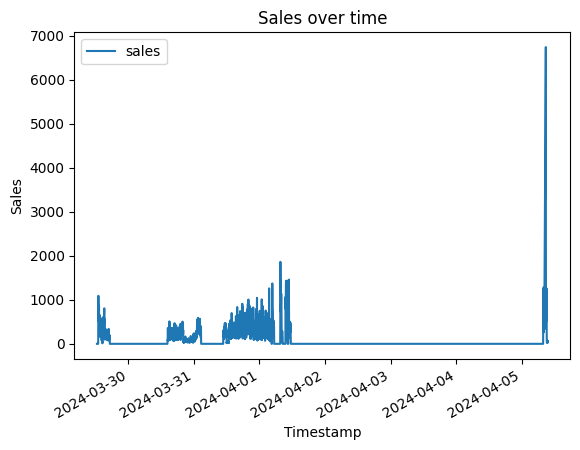

In [6]:
from figures import plot_total_sales


plot_total_sales(df)

<Axes: xlabel='price', ylabel='sales'>

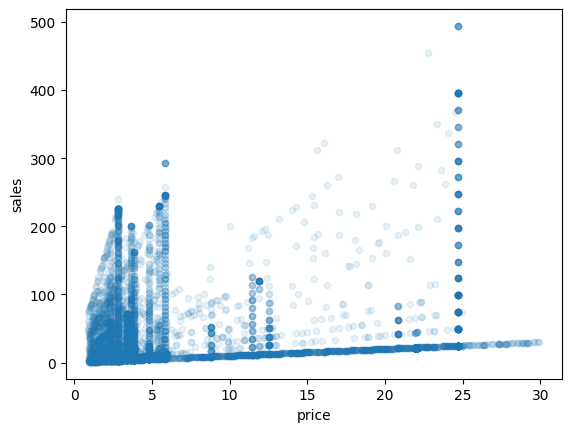